In [33]:
%pip install matplotlib
%pip install darts
%pip install catboost


[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 24.0 -> 25.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [34]:
from datetime import datetime
from darts import TimeSeries
from darts.models import CatBoostModel
import pandas as pd
import os
import kaggle_metric
import utils
from darts.dataprocessing.transformers import Scaler
import matplotlib.pyplot as plt

In [35]:
df = utils.create_df('./data/kernel/receivals.csv')
df = df[df['date_arrival'] > '2021-01-01']
df.head()

,date_arrival,rm_id,net_weight
6045,2021-01-02,342,0.0
6046,2021-01-03,342,0.0
6047,2021-01-04,342,0.0
6048,2021-01-05,342,0.0
6049,2021-01-06,342,0.0


In [36]:
series_lst = TimeSeries.from_group_dataframe(df, 'rm_id', 'date_arrival','net_weight')

In [ ]:
series_dict = {}
train_dict = {}
val_dict = {}
scaler_dict = {}
for i in range(len(series_lst)):
    train_i, val_i = series_lst[i].split_after(0.8)
    rm_id = series_lst[i].static_covariates["rm_id"] if "rm_id" in series_lst[i].static_covariates else None
    rm_id = rm_id.values[0]
    # if (train_i.values() == train_i.values()[0]).all():
    #     print(f"Skipping rm_id {rm_id.values[0]} due to constant training values.")
    #     continue
    
    if train_i.values().std() == 0:
        print(f"Skipping rm_id {rm_id} due to constant training values.")
        continue
    
    scaler = Scaler()
    train_dict[rm_id] = scaler.fit_transform(train_i)           # fit transform on train
    val_dict[rm_id] = val_i                                     # no transform on val original values only used for calculating score
    series_dict[rm_id] = scaler.transform(series_lst[i])        # transform on full series for future preditction
    scaler_dict[rm_id] = scaler

Skipping rm_id 342.0 due to constant training values.
Skipping rm_id 343.0 due to constant training values.
Skipping rm_id 345.0 due to constant training values.
Skipping rm_id 346.0 due to constant training values.
Skipping rm_id 347.0 due to constant training values.
Skipping rm_id 348.0 due to constant training values.
Skipping rm_id 353.0 due to constant training values.
Skipping rm_id 354.0 due to constant training values.
Skipping rm_id 355.0 due to constant training values.
Skipping rm_id 357.0 due to constant training values.
Skipping rm_id 358.0 due to constant training values.
Skipping rm_id 360.0 due to constant training values.
Skipping rm_id 362.0 due to constant training values.
Skipping rm_id 364.0 due to constant training values.
Skipping rm_id 365.0 due to constant training values.
Skipping rm_id 366.0 due to constant training values.
Skipping rm_id 367.0 due to constant training values.
Skipping rm_id 368.0 due to constant training values.
Skipping rm_id 369.0 due to 

In [38]:
model_dict = {}
loss = []

lst = []
for key in train_dict:
    print(f"Training model for rm_id: {key}")
    train_values = train_dict[key].values()
    model = CatBoostModel(lags=30, use_static_covariates=False, random_state=42)
    try:
        model.fit(train_dict[key])
        model_dict[key] = model
        out = model_dict[key].predict(len(val_dict[key]), series=train_dict[key])
        out = scaler_dict[key].inverse_transform(out)
        actual_steps = out.values().clip(min=0)
        actual_steps = actual_steps.cumsum()
        actual_steps[actual_steps < 100] = 0

        # Store predictions and actual values in a dataframe
        df_eval = pd.DataFrame({
            'predicted_weight': actual_steps.flatten(),
            'weight': val_dict[key].cumsum().values().flatten()
        })

    except Exception as e:
        df_eval = pd.DataFrame({
            'predicted_weight': [0]*len(val_dict[key]),
            'weight': val_dict[key].cumsum().values().flatten()
        })
        print(f"Error training model for rm_id {key}: {e}")

    lst.append(df_eval)

df_eval = pd.concat(lst).reset_index(drop=True)
df_eval['ID'] = df_eval.index
score = kaggle_metric.score(df_eval[['ID', 'weight']], df_eval[['ID', 'predicted_weight']])
print(f"Validation score: {score}")
    


Training model for rm_id: 2121.0
Training model for rm_id: 2123.0
Training model for rm_id: 2124.0
Training model for rm_id: 2125.0
Training model for rm_id: 2129.0
Training model for rm_id: 2130.0
Training model for rm_id: 2131.0
Training model for rm_id: 2132.0
Training model for rm_id: 2133.0
Training model for rm_id: 2134.0
Training model for rm_id: 2135.0
Training model for rm_id: 2140.0
Training model for rm_id: 2142.0
Training model for rm_id: 2143.0
Training model for rm_id: 2144.0
Training model for rm_id: 2145.0
Training model for rm_id: 2147.0
Training model for rm_id: 2153.0
Training model for rm_id: 2160.0
Training model for rm_id: 2161.0
Training model for rm_id: 2284.0
Training model for rm_id: 2402.0
Training model for rm_id: 2482.0
Training model for rm_id: 2521.0
Training model for rm_id: 2561.0
Training model for rm_id: 2601.0
Training model for rm_id: 2741.0
Training model for rm_id: 2761.0
Training model for rm_id: 2981.0
Training model for rm_id: 3005.0
Training m

<Axes: >

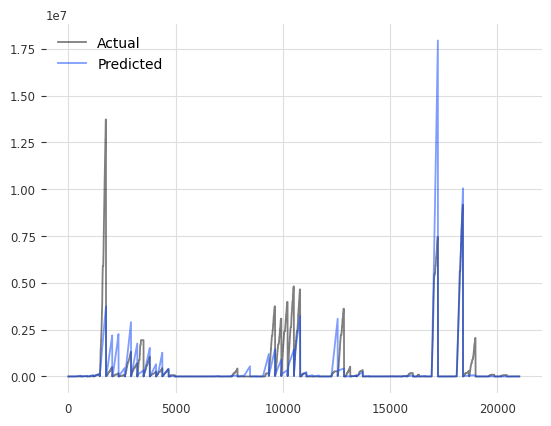

In [43]:
ax = df_eval.plot(y='weight', label='Actual', alpha=0.5)
df_eval.plot(y='predicted_weight', ax=ax, label='Predicted', alpha=0.5)

In [44]:
prediction_mapping = pd.read_csv('./data/prediction_mapping.csv')
prediction_mapping['forecast_start_date'] = pd.to_datetime(prediction_mapping['forecast_start_date'], utc=True).dt.tz_localize(None).dt.normalize()
prediction_mapping['forecast_end_date'] = pd.to_datetime(prediction_mapping['forecast_end_date'], utc=True).dt.tz_localize(None).dt.normalize()
prediction_mapping = prediction_mapping.sort_values(['rm_id', 'forecast_end_date'])
max_date = pd.Timestamp('2025-05-31')
lst = []
for rm_id, group in prediction_mapping.groupby('rm_id'):
    print(f"Processing rm_id {rm_id}")
    if rm_id not in model_dict:
        print(f"No model for rm_id {rm_id}, setting predicted_weight to 0")
        group['predicted_weight'] = 0
    else:
    
        last_train = series_dict[rm_id].time_index[-1]
        n_steps = (max_date - last_train).days - 1
        print(f"Predicting {n_steps} steps for rm_id {rm_id} because last known date is {last_train}")
        out = model_dict[rm_id].predict(n_steps, series=series_dict[rm_id])
        out = scaler_dict[key].inverse_transform(out)
        actual_steps = out.values().clip(min=0)
        actual_steps = actual_steps.cumsum()
        # group['predicted_weight'] = actual_steps
        actual_steps[actual_steps < 100] = 0
        group['predicted_weight'] = actual_steps
    lst.append(group)

df_final = pd.concat(lst)

Processing rm_id 342
No model for rm_id 342, setting predicted_weight to 0
Processing rm_id 343
No model for rm_id 343, setting predicted_weight to 0
Processing rm_id 345
No model for rm_id 345, setting predicted_weight to 0
Processing rm_id 346
No model for rm_id 346, setting predicted_weight to 0
Processing rm_id 347
No model for rm_id 347, setting predicted_weight to 0
Processing rm_id 348
No model for rm_id 348, setting predicted_weight to 0
Processing rm_id 353
No model for rm_id 353, setting predicted_weight to 0
Processing rm_id 354
No model for rm_id 354, setting predicted_weight to 0
Processing rm_id 355
No model for rm_id 355, setting predicted_weight to 0
Processing rm_id 357
No model for rm_id 357, setting predicted_weight to 0
Processing rm_id 358
No model for rm_id 358, setting predicted_weight to 0
Processing rm_id 360
No model for rm_id 360, setting predicted_weight to 0
Processing rm_id 362
No model for rm_id 362, setting predicted_weight to 0
Processing rm_id 364
No m

In [45]:
timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
submission_path = f'./data/submission/submission_{timestamp}.csv'
if not os.path.exists('./data/submission/'):
    os.makedirs('./data/submission/')
    

df_final[['ID', 'predicted_weight']].to_csv(submission_path, index=False)

rm_id
342     Axes(0.125,0.11;0.775x0.77)
343     Axes(0.125,0.11;0.775x0.77)
345     Axes(0.125,0.11;0.775x0.77)
346     Axes(0.125,0.11;0.775x0.77)
347     Axes(0.125,0.11;0.775x0.77)
                   ...             
4461    Axes(0.125,0.11;0.775x0.77)
4462    Axes(0.125,0.11;0.775x0.77)
4463    Axes(0.125,0.11;0.775x0.77)
4481    Axes(0.125,0.11;0.775x0.77)
4501    Axes(0.125,0.11;0.775x0.77)
Name: predicted_weight, Length: 203, dtype: object

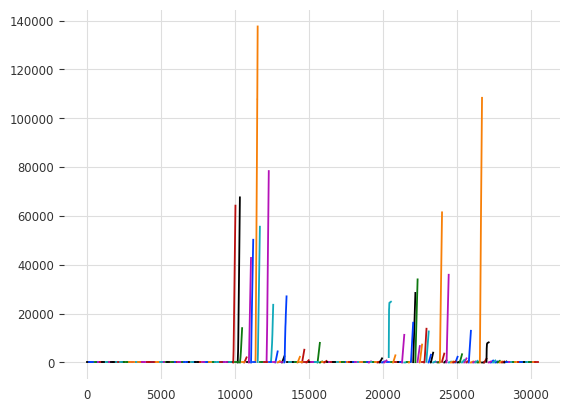

In [47]:
df_final.groupby('rm_id')['predicted_weight'].plot()